<a href="https://colab.research.google.com/github/CSID-DGU/2021-1-OSSP1-Debugger-4/blob/autoencoder/Training_K_Face_model_with_Server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
# 라이브러리 설정
import numpy as np
import cupy
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import gc
import glob
from tensorflow.keras.layers import Reshape
from keras.models import load_model
import keras

# 랜덤 시드 고정
SEED=2021
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# **Load the Dataset for training K-FACE AE Model**

In [ ]:
load_y=np.load('../Upscaling/Dataset_output/NON-WEAR_dataset.npz')  #이미지 데이터가 저장된 NPZ 로드하기.
Y_1 =load_y['arr_0']
load_y.close()
np.random.shuffle(Y_1)

  
Y_test = Y_1[-100:] 
Y_1 = Y_1[:-100]

del load_y
print(Y_1.shape)
gc.collect()

# **Set the distributed training with multiple GPU**

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3","/gpu:4","/gpu:5","/gpu:6","/gpu:7"])

8 Physical GPUs, 8 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


# **Define the Model for K-FACE AE**
# **(INPUT SIZE : 800 x 800)**

In [ ]:

# 오토인코더 모델 정의
def Autoencoder():
  

  with strategy.scope():
      X = tf.keras.layers.Input(shape=[800,800,3])

  #Encoder (Convolution layer 4겹)
      H = tf.keras.layers.Conv2D(3, (3, 3), (2, 2), activation='relu', padding='same')(X)
      H = tf.keras.layers.Conv2D(3 * 2, (3, 3), (2, 2), activation='relu', padding='same')(H)
      H = tf.keras.layers.Conv2D(3 * 4, (3, 3), (2, 2), activation='relu', padding='same')(H)
      H = tf.keras.layers.Conv2D(3 * 8, (3, 3), (2, 2), activation='relu', padding='same')(H)
      H = tf.keras.layers.Conv2D(3 * 16, (3, 3), (2, 2), activation='relu', padding='same')(H)
      H = tf.keras.layers.ZeroPadding2D(((1,0), (0,1)))(H)
      H = tf.keras.layers.Conv2D(3 * 32, (3, 3), (2, 2), activation='relu', padding='same')(H)
    
      pool_temp = H.shape.as_list()
      pool_temp = pool_temp[1:]
    
    #Fully connected
      H = tf.keras.layers.Flatten()(H)
      flatten_temp = H.shape.as_list()
      flatten_temp = flatten_temp[1]
    
      H = tf.keras.layers.Dense(4096, activation='relu')(H)
      H = tf.keras.layers.Dense(flatten_temp, activation='relu')(H)
      H = Reshape(pool_temp)(H)
    
    #Decoder
      H = tf.keras.layers.Conv2DTranspose(3 * 32, (3,3),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 1)))(H)
      H = tf.keras.layers.Conv2DTranspose(3 * 16, (3,3),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.Conv2DTranspose(3 * 8, (3,3),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.Conv2DTranspose(3 * 4, (3,3),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.Conv2DTranspose(3 * 2, (3,3),strides=(2,2),padding='same',activation='relu')(H)
      H = tf.keras.layers.Conv2DTranspose(3, (3,3),strides=(2,2),padding='same',activation='relu')(H)
    
      model = tf.keras.models.Model(X,H)
      model.compile(optimizer='adam',loss='mean_squared_logarithmic_error', metrics=['acc']) #MSLE Loss Funciton 적용
      return model

ae_model = Autoencoder()
ae_model.summary()
#tf.compat.v1.disable_eager_execution()



INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 800, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 400, 400, 3)       84        
_________________________________________________________________
conv2d_1 (Conv2D)            

# **Load the model (Pre-trained Model)**

In [ ]:
from keras.models import load_model
ae_model = load_model('./check/model.h5')

# **Set Model-Checkpoint using Validation accuracy**

In [ ]:
#모델 체크포인트 설정
checkpoint_path = './check/checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only = True,
                                                save_best_only = True,
                                                monitor='val_acc',
                                                verbose=1)


# **Training the AutoEncoder using CNN with K-FACE DataSet**

In [ ]:

history = ae_model.fit(Y_1,
                       Y_1,
                       batch_size=128, #한번에 학습할 데이터 Batch_size
                       epochs=100,      #에포크 설정
                       verbose=1,      #학습과정 시각화     
                       callbacks=[checkpoint],  #모델 체크포인트 저장
                       validation_split=0.2)         

from keras.models import load_model #모델 저장
ae_model.save('./check/model.h5')

Epoch 1/100
140/140 [==============================] - 168s 899ms/step - loss: 0.0871 - acc: 0.4308 - val_loss: 0.0168 - val_acc: 0.4952

Epoch 00001: val_acc improved from -inf to 0.49520, saving model to ./check/checkpoint.ckpt
Epoch 2/100
 25/140 [====>.........................] - ETA: 3:20 - loss: 0.0145 - acc: 0.4882

# **Testing the Pre-trained Model (K-FACE Dataset)**

In [ ]:
ae_images = ae_model.predict(Y_test)  #Pre-trained Model 평가용
ae_images.shape

(100, 800, 800, 3)

# **Show the Image (Pre-trained Model)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


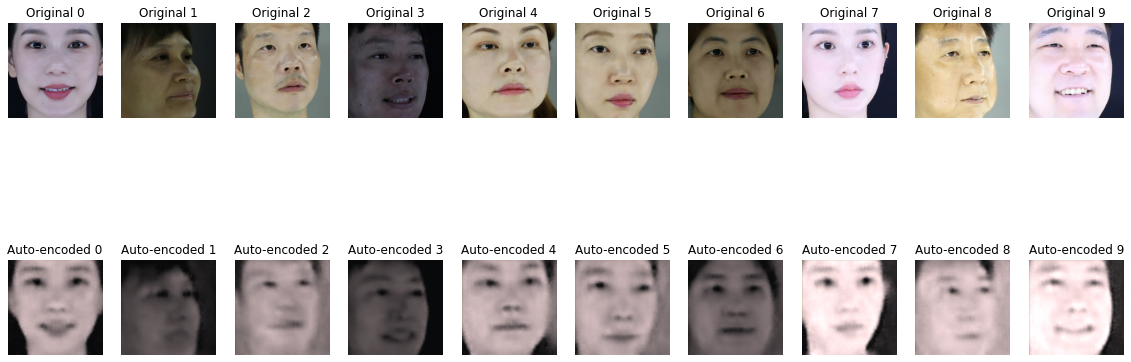

In [ ]:
#이미지 출력
num = 10 
plt.figure(figsize=(20,8))
for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(Y_test[i*10])
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(ae_images[i*10])
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
    
plt.show()